Imports

In [ ]:
import gym
import numpy as np
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

Our functions

In [ ]:
from Train_policy_func import Policy, load_policy
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores, plot_suboptimality_three_policies, plot_scores_RLHF
from OPPO import baseline_CartPole_v0_Fla, OPPO_update, set_seed
from PPO import evaluate_policy
from RLHF import RewardModel, train_policy_from_rollouts_n_updates_v2

## Step 1:
Creating the policies of references, here for three different seeds.

The policies, for CartPole at least are optimised with an OPPO algorithm.
They are saved as "pi1\_ref\_{env_name}\_seed\_{seed}.pth" and "pi2\_ref\_{env_name}\_seed\_{seed}.pth"

In [ ]:
# env 1: CartPole-v0
env_name='CartPole-v0'
env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

baseline = baseline_CartPole_v0_Fla
target_score = 185 # for CartPole-v0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Hyperparams for OPPO ──
lr_oppo                 = 0.003
n_episodes              = 1200 # keep same “number of iterations” for fair comparison
max_t                   = 200  # cap on steps per episode
print_every             = 20   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99


# ── Options for the Run ──
load_policies   = True
evaluate_pi_ref = False
plot_scores     = False
n_eval          = 100

Policy_list     = []
seeds_list      = [35, 42, 100]

for seed in seeds_list:
    set_seed(seed, env)

    if load_policies:
        print(fr"Loading pi_1 and pi_2 with {seed=}")
        pi_1 = load_policy(f"./Policies/pi1_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)

    else:
        print(f"Training pi_1 and pi_2 with seed {seed}")

        pi_1 = Policy(state_size=obs_dim, action_size=action_dim).to(device)
        opt1 = torch.optim.Adam(pi_1.parameters(), lr=lr_oppo)


        scores_oppo = OPPO_update(
            policy          = pi_1,
            optimizer       = opt1,
            env             = env,
            baseline        = baseline,
            n_episodes      = n_episodes,
            max_t           = max_t,
            gamma           = gamma,      # you can reuse your PPO γ
            print_every     = print_every,
            early_stop      = False,
            seed            = seed,
            target_score    = target_score,
            env_name        = env_name,
            display_every   = False
        )


        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
    Policy_list.append([pi_1, pi_2])
    # print("------------------------------------------------------")

print("=================================")



Loading pi_1 and pi_2 with seed=35
Loading pi_1 and pi_2 with seed=42
Loading pi_1 and pi_2 with seed=100


In [ ]:
# ── Evaluate the policies of reference ──
if evaluate_pi_ref:
  print("Evaluating pi_1 and pi_2 for all seeds: \n")
  for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
      
      print(f"Evaluating pi_1 and pi_2 with {seed=} over {n_eval} episodes")
      # Evaluate the policies
      seed_eval = seed+32
      _, pi1_rewards = evaluate_policy(pi_1, env, n_episodes=n_eval, seed=seed_eval)
      _, pi2_rewards = evaluate_policy(pi_2, env, n_episodes=n_eval, seed=seed_eval)
      print(f"Evaluations over {n_eval} episodes done for both policies, using the seed {seed}")
      print(f"\t pi_1({seed}) \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
      print(f"\t pi_2({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")

      if plot_scores:
          plot_Scores(
              pi1_rewards,
              pi2_rewards,
          )
      print("------------------------------------------------------")


  print("=================================")

### Now the Creation/loading of $\pi_{ref}^{1|2}$ is done
***
## We will implement the part RLHF

Note here that we used at first a version of rlhf without PPO-RLHF, we implemented later the wanted algo. Both work :)

In [14]:
# RLHF hyperparameters
lr_RLHF              = 0.009 
n_rollouts_rlhf      = 20       # number of rollouts to collect for the reward model
K                    = 200
beta                 = 0.5
n_train_pi_rlhf      = 100      # very long time to train :)

# PPO-RLHF hyperparameters
lr_PPO_RLHF          = 0.003
n_ppo_updates        = 200      # number of PPO updates
# n_rollouts_ppo_rlhf  = 30       # number of rollouts to collect for the reward model; not used here
max_steps            = 2000      # max steps per episode
beta_ppo             = 5      # KL penalty coefficient
gamma_PPO            = 0.98
lambda_ppo           = 0.95 # 0.95
clip_eps             = 0.2
c1                   = 0.5         
c2                   = 0.1 # 0.1        
# rest of the parameters are the ones by default in PPO (see RLHF.py)


# Parameters for the RLHF part
# n_pairs              = 200 # number of preference pairs to collect
pair_list          = [20, 50, 200] # number of preference pairs to collect
load_rlhf_policies   = True
pi_ref_rlhf          = 1
load_pi2_start_rlhf  = True
plot_scores          = True
n_eval               = 100
compare_policies     = True

# Store the policies from RLHF learning
Policy_rlhf_list     = []
# Store the policies from PPO-RLHF learning
Policy_pporlhf_list  = []
for n_pair in pair_list:
    print(f"=============== using {n_pair=} ==================")
    # Pol_pair_rlhf     = []
    Pol_pair_pporlhf  = []
    for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
        print(f"Seed {seed}")
        # Create the policy that will be trained with RLHF        
        # policy_RLHF     = Policy(state_size= obs_dim, action_size= action_dim).to(device)
        policy_PPO_RLHF = Policy(state_size= obs_dim, action_size= action_dim).to(device)

        if load_rlhf_policies:
            # policy_RLHF     = load_policy(fr"./Policies/pi_RLHF_{env_name}_seed_{seed}_beta{beta}_Npair_{n_pair}.pth", obs_dim, action_dim, device)
            policy_PPO_RLHF = load_policy(fr"./Policies/pi_PPO_RLHF_{env_name}_seed_{seed}_beta{beta_ppo}_Npairs_{n_pair}.pth", obs_dim, action_dim, device)
            print(f"Loading policy trained with RLHF for {seed=}")
        else:
            # -- Reward model -- 
            # Create the reward model
            print(f"Loading reward model trained on {n_pair} preference pairs")
            reward_model = RewardModel(state_dim=obs_dim, action_dim=action_dim).to(device)
            reward_model.load_state_dict(torch.load(fr"./Policies/reward_model_{env_name}_Npairs_{n_pair}.pth"))

            # -- Starting point of the policy --
            if load_pi2_start_rlhf: 
                # Starting point of the policy is pi_2
                # policy_RLHF.load_state_dict(torch.load(fr"./Policies/pi2_ref_{env_name}_seed_{seed}.pth"))
                policy_PPO_RLHF.load_state_dict(torch.load(fr"./Policies/pi2_ref_{env_name}_seed_{seed}.pth"))
            # opt_RLHF        = torch.optim.Adam(policy_RLHF.parameters(),     lr=lr_RLHF)
            opt_PPO_RLHF    = torch.optim.Adam(policy_PPO_RLHF.parameters(), lr=lr_PPO_RLHF)

            # -- Training the new policy --
            policy_ref = pi_1 if pi_ref_rlhf == 1 else pi_2

            # print(f"Training policy with RLHF using pi_{pi_ref_rlhf} as reference policy and {n_pair} preference pairs")
            # train_policy_from_rollouts_n_updates(policy_RLHF, policy_ref, reward_model, env, opt_RLHF, N=n_train_pi_rlhf, K=n_rollouts_rlhf, max_steps=500, beta=beta)
            # torch.save(policy_RLHF.state_dict(), fr"./Policies/pi_RLHF_{env_name}_seed_{seed}_beta{beta}_Npairs_{n_pair}.pth")
            # print(fr"Saved final policy in ./Policies/pi_RLHF_{env_name}_seed_{seed}_beta{beta}.pth")
            
            print(f"Training policy with PPO-RLHF using pi_{pi_ref_rlhf} as reference policy and {n_pair} preference pairs")
            train_policy_from_rollouts_n_updates_v2(policy_PPO_RLHF, policy_ref, reward_model, env, opt_PPO_RLHF, N=n_ppo_updates, max_steps=max_steps, beta=beta_ppo,gamma=gamma_PPO, lam=lambda_ppo, clip_eps=clip_eps, c1=c1, c2=c2)
            torch.save(policy_PPO_RLHF.state_dict(), fr"./Policies/pi_PPO_RLHF_{env_name}_seed_{seed}_beta{beta_ppo}_Npairs_{n_pair}.pth")
            print(fr"Saved final policy in ./Policies/pi_PPO_RLHF_{env_name}_seed_{seed}_beta{beta_ppo}_Npairs_{n_pair}.pth")
        # Pol_pair_rlhf.append(policy_RLHF)
        Pol_pair_pporlhf.append(policy_PPO_RLHF)
    # Policy_rlhf_list.append(Pol_pair_rlhf)
    Policy_pporlhf_list.append(Pol_pair_pporlhf)
print("=================================")



=============== using n_pair=20 ==================
Seed 35
Loading policy trained with RLHF for seed=35
Seed 42
Loading policy trained with RLHF for seed=42
Seed 100
Loading policy trained with RLHF for seed=100
=============== using n_pair=50 ==================
Seed 35
Loading policy trained with RLHF for seed=35
Seed 42
Loading policy trained with RLHF for seed=42
Seed 100
Loading policy trained with RLHF for seed=100
=============== using n_pair=200 ==================
Seed 35
Loading policy trained with RLHF for seed=35
Seed 42
Loading policy trained with RLHF for seed=42
Seed 100
Loading policy trained with RLHF for seed=100


Evaluating pi_RLHF and pi_PPO_RLHF for all seeds and dataset size over 100 Runs 

=============== using n_pair=20 ==================
Evaluations over 100 episodes done for the 3 policies, averaged over the 3 seeds for n_pair=20
pi_1(20)        	 mean reward: 	 189.48 ± 13.83
pi_2(20)        	 mean reward: 	 110.39 ± 28.32
pi_PPO_RLHF(20) 	 mean reward: 	 176.83 ± 21.08
------------------------------------------------------
=============== using n_pair=50 ==================
Evaluations over 100 episodes done for the 3 policies, averaged over the 3 seeds for n_pair=50
pi_1(50)        	 mean reward: 	 188.95 ± 14.11
pi_2(50)        	 mean reward: 	 110.18 ± 26.01
pi_PPO_RLHF(50) 	 mean reward: 	 186.61 ± 17.30
------------------------------------------------------
=============== using n_pair=200 ==================
Evaluations over 100 episodes done for the 3 policies, averaged over the 3 seeds for n_pair=200
pi_1(200)        	 mean reward: 	 186.49 ± 19.34
pi_2(200)        	 mean reward:

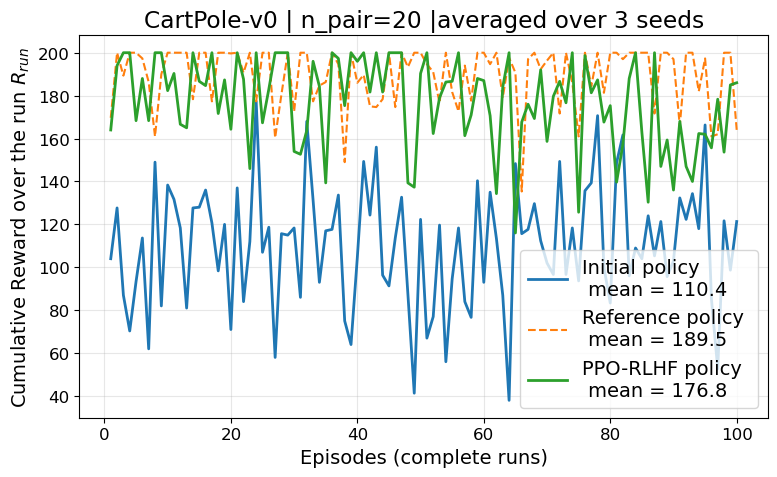

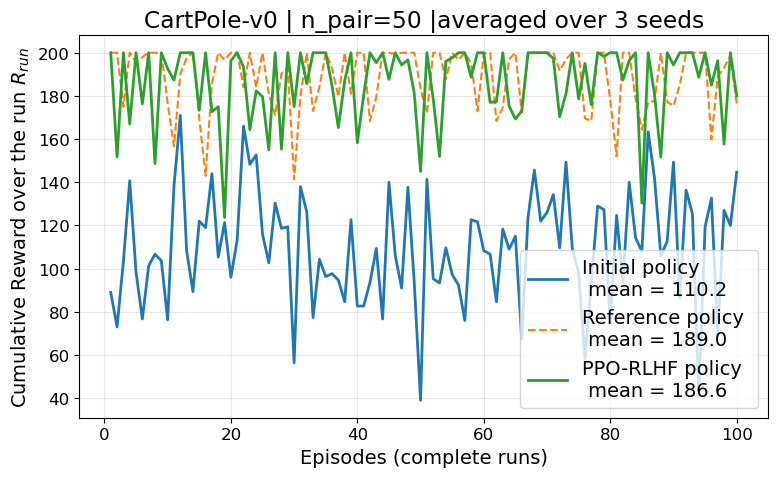

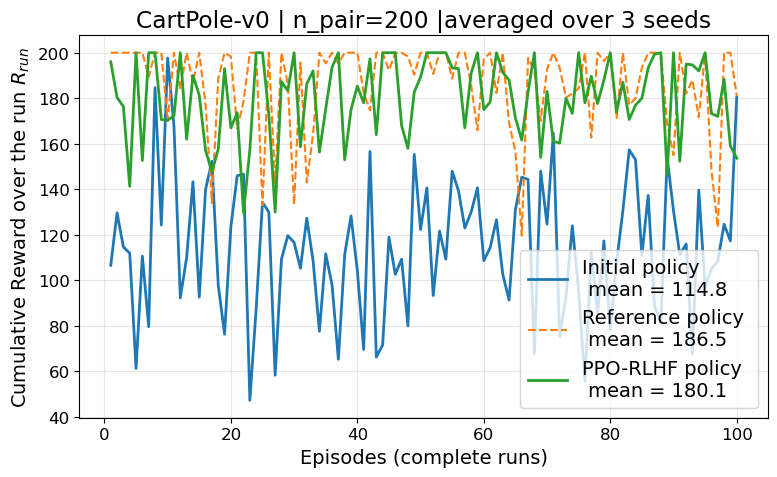

In [15]:
print(f"Evaluating pi_RLHF and pi_PPO_RLHF for all seeds and dataset size over {n_eval} Runs \n")


for i, n_pair in enumerate(pair_list):
    print(f"=============== using {n_pair=} ==================")    
    R_ref = 0
    R_init = 0
    R_ppo_rlhf = 0
    
    for seed, (pi_1, pi_2), pi_ppo_rlhf in zip(seeds_list, Policy_list, Policy_pporlhf_list[i]):
        seed_eval = seed+34
        _, pi1_rewards          = evaluate_policy(pi_1,     env, n_episodes=n_eval, seed=seed_eval)
        _, pi2_rewards          = evaluate_policy(pi_2,     env, n_episodes=n_eval, seed=seed_eval)
        _, pi_ppo_rlhf_rewards  = evaluate_policy(pi_ppo_rlhf, env, n_episodes=n_eval, seed=seed_eval)
        # _, pi_rlhf_rewards      = evaluate_policy(pi_rlhf,  env, n_episodes=n_eval, seed=seed_eval)

        # print(pi1_rewards, np.mean(pi1_rewards), np.std(pi1_rewards))
        R_ref       += np.array(pi1_rewards)/len(seeds_list)
        R_init      += np.array(pi2_rewards)/len(seeds_list)
        R_ppo_rlhf  += np.array(pi_ppo_rlhf_rewards)/len(seeds_list)
        
    if compare_policies:
        print(f"Evaluations over {n_eval} episodes done for the 3 policies, averaged over the 3 seeds for {n_pair=}")
        print(f"pi_1({n_pair})        \t mean reward: \t {np.mean(R_ref):.2f} ± {np.std(R_ref):.2f}")
        print(f"pi_2({n_pair})        \t mean reward: \t {np.mean(R_init):.2f} ± {np.std(R_init):.2f}")
        # print(f"pi_RLHF({seed})     \t mean reward: \t {np.mean(pi_rlhf_rewards):.2f} ± {np.std(pi_rlhf_rewards):.2f}")
        print(f"pi_PPO_RLHF({n_pair}) \t mean reward: \t {np.mean(R_ppo_rlhf):.2f} ± {np.std(R_ppo_rlhf):.2f}")
    if plot_scores:
        plot_scores_RLHF(R_init, R_ref, R_ppo_rlhf, algo="PPO-RLHF", save=True, n_pair=n_pair, env_name=env_name)

        print("------------------------------------------------------")



***
# The following was to analyse RLHF and PPO-RLHF separately


In [16]:
# if compare_policies:
#     print("Evaluating pi_RLHF and pi_PPO_RLHF for all seeds and dataset size \n")
#     for n_pair in pair_list:
#         print(f"=============== using {n_pair=} ==================")    
#         for seed, (pi_1, pi_2), pi_rlhf, pi_ppo_rlhf in zip(seeds_list, Policy_list, Policy_rlhf_list, Policy_pporlhf_list):
            
#             seed_eval = seed+32
#             _, pi1_rewards          = evaluate_policy(pi_1,     env, n_episodes=n_eval, seed=seed_eval)
#             _, pi2_rewards          = evaluate_policy(pi_2,     env, n_episodes=n_eval, seed=seed_eval)
#             # _, pi_rlhf_rewards      = evaluate_policy(pi_rlhf,  env, n_episodes=n_eval, seed=seed_eval)
#             _, pi_ppo_rlhf_rewards  = evaluate_policy(pi_ppo_rlhf, env, n_episodes=n_eval, seed=seed_eval)
            
#             print("Evaluations over", n_eval, "episodes done for the 4 policies, using the seed {seed}")
#             print(f"pi_1({seed})        \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
#             print(f"pi_2({seed})        \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
#             # print(f"pi_RLHF({seed})     \t mean reward: \t {np.mean(pi_rlhf_rewards):.2f} ± {np.std(pi_rlhf_rewards):.2f}")
#             print(f"pi_PPO_RLHF({seed}) \t mean reward: \t {np.mean(pi_ppo_rlhf_rewards):.2f} ± {np.std(pi_ppo_rlhf_rewards):.2f}")
#             if plot_scores:
#                 plot_scores_RLHF(pi2_rewards, pi1_rewards, pi_ppo_rlhf_rewards, algo="PPO-RLHF")

#             print("------------------------------------------------------")



***
## RLHF:

In [17]:
# for seed, (pi_1, pi_2), pi_rlhf in zip(seeds_list, Policy_list, Policy_rlhf_list):
#   print(f"Evaluating pi_1, pi_2 and pi_RLHF with {seed=}, {beta=} over {n_eval} episodes")
#   # Evaluate the policies
#   seed_eval = seed+32
#   _, pi1_rewards     = evaluate_policy(pi_1,        env, n_episodes=n_eval, seed=seed_eval)
#   _, pi_rlhf_rewards   = evaluate_policy(pi_rlhf,     env, n_episodes=n_eval, seed=seed_eval)
#   _, pi2_rewards      = evaluate_policy(pi_2,       env, n_episodes=n_eval, seed=seed_eval)
#   print(f"Evaluations over {n_eval} episodes using the evalutation seed {seed_eval}")
#   print(f"pi_1({seed})      \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
#   print(f"pi_INIT({seed})   \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
#   print(f"pi_RLHF({seed})   \t mean reward: \t {np.mean(pi_rlhf_rewards):.2f} ± {np.std(pi_rlhf_rewards):.2f}")

#   plot_scores_RLHF(
#       pi2_rewards,
#       pi1_rewards,
#       pi_rlhf_rewards,
#       algo="RLHF"
#   )
#   print("-------------------------------------")

***
## PPO-RLHF:

In [18]:
# for seed, (pi_1, pi_2), pi_rlhf in zip(seeds_list, Policy_list, Policy_pporlhf_list):
#   print(f"Evaluating pi_1, pi_2 and pi_PPO_RLHF with {seed=}, {beta=} over {n_eval} episodes")
#   # Evaluate the policies
#   seed_eval = seed+32
#   _, pi1_rewards     = evaluate_policy(pi_1,        env, n_episodes=n_eval, seed=seed_eval)
#   _, pi_rlhf_rewards   = evaluate_policy(pi_rlhf,     env, n_episodes=n_eval, seed=seed_eval)
#   _, pi2_rewards      = evaluate_policy(pi_2,       env, n_episodes=n_eval, seed=seed_eval)
#   print(f"Evaluations over {n_eval} episodes using the evalutation seed {seed_eval}")
#   print(f"pi_1({seed})        \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
#   print(f"pi_INIT({seed})     \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
#   print(f"pi_PPO_RLHF({seed}) \t mean reward: \t {np.mean(pi_rlhf_rewards):.2f} ± {np.std(pi_rlhf_rewards):.2f}")

#   plot_scores_RLHF(
#       pi2_rewards,
#       pi1_rewards,
#       pi_rlhf_rewards,
#       algo="PPO-RLHF"
#   )
#   print("-------------------------------------")